# Alzheimer's Disease Neuroimaging Initiative

In [178]:
from IPython.core.display import HTML
with open("project.css") as css:
    styles = css.read()
HTML(styles)

## ADNI

The overarching goal of the Alzheimer's Disease Neuroimaging Initiative (ADNI) is to identify biomarkers of Alzheimer’s disease. Specifically the study aims at identifying those biomarkers that can be used in the earliest (pre-dementia) prediction of Alzheimer's Disease (AD). The study began in 2004, a time when biomarkers for Alzheimer’s disease which could be used for diagnostics in pre-dementia individuals were virtually unknown. There are four categories of biomarkers in the scope of the initiative: (clinical, imaging, genetic, and biochemical).

There have been ADNI 4 study phases to date with the following goals:

<!-- Begin ADNI Phase table -->

| Study Phase | Goal | Dates | Cohort |
|:---: |:--- |:--- | --- |
| ADNI 1 | Develop biomarkers as outcome measures for clinical trials | 2004-2009 | 200 elderly controls<br>400 MCI<br>200 AD |
| ADNI GO | Examine biomarkers in earlier stages of disease | 2009-2011 | Existing ADNI-1 +<br>200 early MCI |
| ADNI 2 | Develop biomarkers as predictors of cognitive decline, and as outcome measures | 2011-2016 | Existing ADNI-1 and ADNI-GO +<br>150 elderly controls<br>100 early MCI<br>150 late MCI<br>150 AD |
| ADNI 3 | Study the use of tau PET and functional imaging techniques in clinical trials | 2016 - present | Existing ADNI-1, ADNI-GO, ADNI-2 +<br>133 elderly controls<br>151 MCI<br>87 AD |

<!-- End ADNI phase table -->

## ADNI Data
Before looking at a single observation or feature, there is a lot of information we can glean from reviewing ADNI metadata. There are over 250 datasets in the ADNI data inventory spanning the 4 study phases (ADNI 1, GO, 2, 3) - and this number does not include the archives. These studies are longitudinal. ADNI-1 started in 2004 and ADNI-3 continues today. Although there is potentially a wealth of information, insights, and predictive power in these data, their data collection methods and longitudinal nature present many challenges.

One challenge is that all biometrics within the scope of the study are not collected across all study phases. Also, within each phase, not all participants had all measurements taken. For example, in ADNI-1, $100\%$ of the cohort had a 1.5 Tesla (1.5T) MRI, $50\%$ had a PET scan. Of the $50\%$ that didn't have a PET scan, $25\%$ had a 3T MRI. Finally, only $20\%$ of the ADNI-1 cohort had a lumbar puncture (L.P.) to collect cerebral spinal fluid (CSF).

Other data challenges are related to the longitudinal nature of the studies across the different phases. In each successive phase of the study, participants were rolled over from previous phases while new participants were also added - *(cohort details can be seen in the table above)*. However, existing participants in the study must provide their consent to be included in each subsequent phase. Furthermore, an obvious, but nonetheless real, complication with this population is that a participant could be removed from the study at any time due to significant deterioration in health or death. 

The result is that each phase of the study produces a richer set of longitudinal data than the previous study because of the rollover participants. The downside of this design is the inherent introduction of missingness into the data due to the recently joined participants.

### An initial look at the data.
Given the breadth of available data and the challenges mentioned above, deciding what data to use to start EDA is a non-trivial task. Fortunately, there is a combined dataset available consisting of key ADNI tables merged into a single table based on the patient identifier or `RID`. As is common with most ADNI datasets, each observation represents a single visit for a participant. This means that a single participant (`RID`) may appear multiple times in the dataset. The number of occurrences will generally depend on what phase the participant entered the study.

Let's take an initial look at the merged dataset.

In [179]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ADNI_utilities

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import linear_model


In [180]:
adni_merge = pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)

In [181]:
print("The shape of the dataset is {}.".format(adni_merge.shape))
print("There are {} unique participants in the dataset."
      .format(len(adni_merge.RID.unique())))
print("There is an average of {:.2f} rows in the data per participant."
      .format(len(adni_merge)/len(adni_merge.RID.unique())))

The shape of the dataset is (13632, 113).
There are 2081 unique participants in the dataset.
There is an average of 6.55 rows in the data per participant.


As seen above, the dataset contains $2081$ unique study participants spanning $13632$ visits. The data is longitudinal based on participant visits spaced roughly six months apart. The `VISCODE` feature represents the visit in which the measurements and evaluations were captured. The initial evaluation measurements are identified by `VISCODE` = `'bl'`, which stands for baseline. Below are the unique `VISCODE` values in the dataset:

In [182]:
adni_merge.sort_values(by='Month')['VISCODE'].unique()

array(['bl', 'm03', 'm06', 'm12', 'm18', 'm24', 'm36', 'm30', 'm42',
       'm48', 'm54', 'm60', 'm66', 'm72', 'm78', 'm84', 'm90', 'm96',
       'm102', 'm108', 'm114', 'm120', 'm126', 'm132', 'm144', 'm156'],
      dtype=object)

Let's visualize the number of study participants per `VISCODE`.

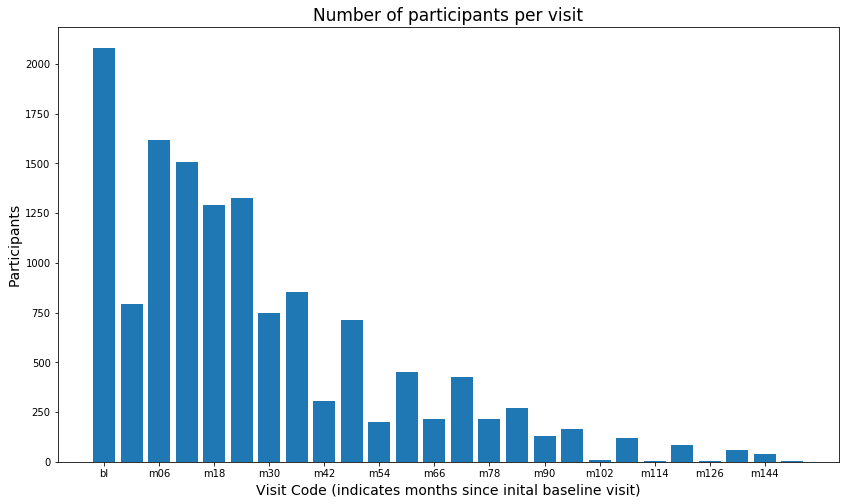

In [183]:
# M represents months since the last visit (0 = baseline/initial visit)
adni_by_month = adni_merge.groupby(by='M').count()
particpants = adni_by_month['RID']
visits = adni_merge.sort_values(by='M')['VISCODE'].unique()

fig, ax = plt.subplots(1, 1, figsize=(14,8))

ax.set_title('Number of participants per visit', size=17)
ax.set_xticks(range(0, 26, 2))
ax.set_xlabel('Visit Code (indicates months since inital baseline visit)', size=14)
ax.set_ylabel('Participants', size=14)
ax.bar(visits, particpants)

plt.show()

Based on the design of the study as discussed above, we expect there to be a lot of missing data in this data set. Let's take a look.

In [184]:
# Calculate missing data
missing_data = utils.calculate_missing_data(adni_merge)

# Look at the top 10 columns in terms of missing values
missing_data.head(10)

There are a total of 507270 missing values.
Out of 113 features in the dataset, 93 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25       3839.0     28.161678
0.50       6185.0     45.371185
0.75       7758.0     56.910211
1.00      13632.0    100.000000


,Num Missing,Pct. Missing
FLDSTRENG_bl,13632.0,100.000000
FLDSTRENG,13632.0,100.000000
PIB_bl,13483.0,98.906984
PIB,13409.0,98.364143
PTAU,11262.0,82.614437
ABETA,11261.0,82.607101
TAU,11261.0,82.607101
AV45,11122.0,81.587441
FDG,10125.0,74.273768
DIGITSCOR,9832.0,72.124413


We've noticed that the numbers of non-null values for `PTAU`, `ABETA`, and `TAU` are suspiciously close to the number of unique participants. The fact that these features all have almost the exact same number of missing values could be an artifact of how and when these data were collected. Perhaps these were collected on the initial baseline `bl` visit.

In [185]:
missing_proteins = missing_data.loc[['TAU', 'PTAU', 'ABETA']]
missing_proteins['Num Values Present'] = len(adni_merge) - missing_proteins['Num Missing']
missing_proteins['Num Participants'] = len(adni_merge.RID.unique())
missing_proteins

,Num Missing,Pct. Missing,Num Values Present,Num Participants
TAU,11261.0,82.607101,2371.0,2081
PTAU,11262.0,82.614437,2370.0,2081
ABETA,11261.0,82.607101,2371.0,2081


There are many options to deal with the variable number of visits in the merged data set. Instead of vertically stacking the visits as in the merged dataset, we could split on `VISCODE` and stack the data *horizontally* creating wide rows with many more features. However, this is essentially transposing the data and moving the missing values from deep columns to wide rows. Another option is to split the data into multiple subsets of data based on `VISCODE` and deal with them separately. As shown in the "*Participants per visit*" figure, every participant had at least a baseline visit. This subset should provide the most complete and uniform representation of the data.

In [186]:
baseline = adni_merge[adni_merge['VISCODE'] == 'bl'].copy()
print('Shape of the baseline visit subset: ', baseline.shape)

baseline.head()

Shape of the baseline visit subset:  (2081, 113)


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,...,153.1,13.29,NaN,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
10,5,011_S_0005,bl,11,ADNI1,ADNI1,2005-09-07,CN,73.7,Male,...,337,33.43,1.29343,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0
15,6,100_S_0006,bl,100,ADNI1,ADNI1,2005-11-29,LMCI,80.4,Female,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2018-10-19 22:51:15.0


Let's examime the missing data from the baseline visit dataset.

In [187]:
# Calculate missing data
missing_data = utils.calculate_missing_data(baseline)

There are a total of 54057 missing values.
Out of 113 features in the dataset, 91 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25         22.0      1.057184
0.50        728.0     34.983181
0.75        851.0     40.893801
1.00       2081.0    100.000000


## Filling in Missing Data
Based on the study data, we know that not all biometrics are measured at every visit. Therefore we may be able to pull measures together from different visits to help fill in missing data. Of course since we're dealing with longitudinal data with visits month or years apart, we have to make sure that we only consider measures from visits where the diagnosis code is unchanged.

In [188]:
# For every column in the baseline (VISCODE='bl') with missing values, look for
# a value in subsequent visits with the constraint that the DX code must
# not have changed. Take the first (earliest) biometric measure available.

baseline.sort_values(by='RID')
missing_cols = baseline.columns[baseline.isnull().any()]
viscodes = list(adni_merge.sort_values(by='Month')['VISCODE'].unique())
viscodes.pop(0) # Get rid of 'bl'

missing_values = baseline.isnull().sum().sum()
updated_values = 0

print('Searching...')
for col in missing_cols:
    
    for v in viscodes:
        
        # Get the RIDs with missing values in this colummn.
        # Do this for each VISCODE since we are iteratively
        # updating missing values.
        rids = baseline[baseline[col].isnull()].RID
        
        # Create a DataFrame from adni_merge for the current
        # VISCODE, RIDs, & where current col is not null.
        df = adni_merge.loc[(adni_merge.RID.isin(rids))
                            & (adni_merge.VISCODE == v)
                            & (adni_merge[col].notnull()),
                            baseline.columns] 
               
        if df.empty: # if no matches, continue
            continue
            
        df = df.copy()
        df.sort_values(by='RID', inplace=True)
            
        # Find baseline participants who are also in the current VISCODE
        bl = baseline[baseline.RID.isin(df.RID)].copy()
        bl.sort_values(by='RID', inplace=True)
        df.index = bl.index
        
        # Only keep those where the diagnosis is unchanged & col is not null
        df = df[(df.DX == bl.DX) & (df[col].notnull())]

        if df.empty:  # if DX codes don't match, continue
            continue

        # Update null values in the original baseline DF
        baseline.loc[baseline.index.isin(df.index), col] = df[col]
        updated_values += len(df)

print(f'Updated {updated_values} of {missing_values} missing values.')

Searching...
Updated 4104 of 54057 missing values.


In [189]:
# Calculate missing data
missing_data = utils.calculate_missing_data(baseline)

# Look at the top 10 columns in terms of missing values
missing_data.head(10)

There are a total of 49953 missing values.
Out of 113 features in the dataset, 91 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25         21.0      1.009130
0.50        641.0     30.802499
0.75        832.0     39.980778
1.00       2081.0    100.000000


,Num Missing,Pct. Missing
FLDSTRENG,2081.0,100.000000
FLDSTRENG_bl,2081.0,100.000000
PIB_bl,2061.0,99.038924
PIB,1990.0,95.627102
DIGITSCOR_bl,1267.0,60.884190
DIGITSCOR,1264.0,60.740029
AV45_bl,1107.0,53.195579
AV45,971.0,46.660259
EcogSPOrgan_bl,891.0,42.815954
PTAU_bl,866.0,41.614608


Clearly a lot of missing data remain and we will likely have to explore methods to impute these values. Before doing that however, we will explore the data a little closer to see if there are features that should be dropped due to high correlation, lack of information, or other reasons.

`FLDSTRENG` and `FLDSTRENG_bl` are providing absolutely no information so we can drop them.

In [190]:
baseline = baseline.drop(labels=['FLDSTRENG', 'FLDSTRENG_bl'], axis=1)

There appears to be a lot of features with similar, if not identical, information such as `TAU`, `TAU_bl`, `AV45`, `AV45_bl`. Let's examine this pattern to see if these pairs are highly correlated.

In [191]:
# Generate a correlation matrix of xxx_bl vs xxx
corr_df = baseline.corr()
cols = baseline.columns
col1, col2, corr = [], [], []

# Specifically check the correlation of xxx_bl to xxx
for col in cols:
    if '_bl' in col.lower(): 
        drop_bl = col[0:-3]
        if (drop_bl in cols):
            if (col in corr_df.index and corr_df.loc[col][drop_bl] > .8):
                col1.append(col)
                col2.append(drop_bl)
                corr.append(corr_df.loc[col][drop_bl])

# Display the results                
bl_corr_df = pd.DataFrame({"Baseline column": col1, 'Alternate column': col2, "Correlation": corr})
bl_corr_df

,Baseline column,Alternate column,Correlation
0,CDRSB_bl,CDRSB,1.0
1,ADAS11_bl,ADAS11,1.0
2,ADAS13_bl,ADAS13,1.0
3,ADASQ4_bl,ADASQ4,1.0
4,MMSE_bl,MMSE,1.0
5,RAVLT_immediate_bl,RAVLT_immediate,1.0
6,RAVLT_learning_bl,RAVLT_learning,1.0
7,RAVLT_forgetting_bl,RAVLT_forgetting,1.0
8,RAVLT_perc_forgetting_bl,RAVLT_perc_forgetting,1.0
9,LDELTOTAL_BL,LDELTOTAL,1.0


These features indeed contain duplicate information so we can drop one of each pair.

In [192]:
baseline = baseline.drop(labels=bl_corr_df['Baseline column'].values, axis=1)
print("The new shape of the baseline subset is {}.".format(baseline.shape))

The new shape of the baseline subset is (2081, 71).


In [193]:
# Let's see what features we have now
baseline.columns.sort_values()

Index(['ABETA', 'ABETA_bl', 'ADAS11', 'ADAS13', 'ADASQ4', 'AGE', 'APOE4',
       'AV45', 'CDRSB', 'COLPROT', 'DIGITSCOR', 'DX', 'DX_bl', 'EXAMDATE',
       'EXAMDATE_bl', 'EcogPtDivatt', 'EcogPtLang', 'EcogPtMem', 'EcogPtOrgan',
       'EcogPtPlan', 'EcogPtTotal', 'EcogPtVisspat', 'EcogSPDivatt',
       'EcogSPLang', 'EcogSPMem', 'EcogSPOrgan', 'EcogSPPlan', 'EcogSPTotal',
       'EcogSPVisspat', 'Entorhinal', 'FAQ', 'FDG', 'FSVERSION',
       'FSVERSION_bl', 'Fusiform', 'Hippocampus', 'ICV', 'IMAGEUID',
       'LDELTOTAL', 'M', 'MMSE', 'MOCA', 'MidTemp', 'Month', 'Month_bl',
       'ORIGPROT', 'PIB', 'PTAU', 'PTAU_bl', 'PTEDUCAT', 'PTETHCAT',
       'PTGENDER', 'PTID', 'PTMARRY', 'PTRACCAT', 'RAVLT_forgetting',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_perc_forgetting', 'RID',
       'SITE', 'TAU', 'TAU_bl', 'TRABSCOR', 'VISCODE', 'Ventricles',
       'WholeBrain', 'Years_bl', 'mPACCdigit', 'mPACCtrailsB', 'update_stamp'],
      dtype='object')

We still have some columns that look very similar. These may contain non-numeric values such as strings or NaNs, or possibly they are really uncorrelated.

In [194]:
# Columns to check for duplicates
cols = ['ABETA', 'DX', 'EXAMDATE','FSVERSION',  'PTAU', 'TAU']

bl_missing = []
missing = []
matching_vals = []

for col in cols:
    missing.append(baseline[col].isnull().sum())
    bl_missing.append(baseline[col+'_bl'].isnull().sum())
    match = (baseline[col] == baseline[col+'_bl']).sum()
    matching_vals.append((match + min(missing[-1], bl_missing[-1]))/len(baseline) * 100)
                 
# Display the results                
bl_dupes = pd.DataFrame({'Missing Values': missing,
                            'Baseline Missing Values': bl_missing,
                            'Percent Matching': matching_vals}, index=cols)
bl_dupes

,Missing Values,Baseline Missing Values,Percent Matching
ABETA,832,866,98.366170
DX,25,16,24.939933
EXAMDATE,0,0,100.000000
FSVERSION,346,357,99.471408
PTAU,832,866,98.366170
TAU,832,866,98.366170


All of the pairs are nearly exact duplicates except `DX`|`DX_bl`, so we can drop one of the duplicate columns. The baseline version has slightly more missing data, so we'll drop that one. Then we'll take a look at `DX` vs.`DX_bl`.

In [195]:
# Get a list of duplicate column names to drop
dupe_cols = [col + '_bl' for col in cols]

# Remove DX_bl until we investigate further
del dupe_cols[dupe_cols.index('DX_bl')]

# Drop the columns
baseline = baseline.drop(labels=dupe_cols, axis=1)

In [196]:
# See how DX maps to DX_bl
baseline.drop_duplicates('DX_bl')[['DX_bl', 'DX']]

,DX_bl,DX
0,CN,CN
1,AD,Dementia
5,LMCI,MCI
48,SMC,CN
2848,EMCI,MCI
11389,NaN,NaN


Although similar, the diagnoses in `DX_bl` are more specific than those in `DX`. We'll use the more standard diagnosis codes in `DX`, however `DX_bl` has slightly less missingness. We'll drop `DX` and keep `DX_bl`, but we'll remap some of the values.

In [197]:
# Drop DX
baseline = baseline.drop(labels=['DX'], axis=1)

# Remap some of the DX_bl values
baseline.DX_bl = baseline.DX_bl.replace('LMCI','MCI')
baseline.DX_bl = baseline.DX_bl.replace('EMCI','MCI')
baseline.DX_bl = baseline.DX_bl.replace('SMC','CN')

We also have some participants for which we have no diagnosis code, so these records will not be useful and can be dropped.

In [198]:
missing_dx = len(baseline[baseline['DX_bl'].isnull()])
baseline = baseline.dropna(axis=0, subset=['DX_bl'])
print(f'Removed {missing_dx} participants with no diagnosis code.')

Removed 16 participants with no diagnosis code.


`PTID` is also duplicative. It is a combination of `RID` and `SITE`.

In [199]:
baseline = baseline.drop(labels='PTID', axis=1)

In [200]:
print("The new shape of the baseline subset is {}.".format(baseline.shape))
utils.calculate_missing_data(baseline)

The new shape of the baseline subset is (2065, 64).
There are a total of 20821 missing values.
Out of 64 features in the dataset, 44 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25        22.75      1.101695
0.50       541.50     26.222760
0.75       649.00     31.428571
1.00      1974.00     95.593220


,Num Missing,Pct. Missing
PIB,1974.0,95.593220
DIGITSCOR,1248.0,60.435835
AV45,956.0,46.295400
ABETA,816.0,39.515738
TAU,816.0,39.515738
PTAU,816.0,39.515738
EcogSPOrgan,670.0,32.445521
EcogSPDivatt,656.0,31.767554
EcogSPVisspat,654.0,31.670702
EcogSPPlan,651.0,31.525424


In the new dataset, it is clear that `PIB` will not be useful and can be removed. PIB or *PiB* stands for **Pi**ttsburgh Compound-**B** - a synthetic radiotracer developed for use in PET scans to visualize and measure A$\beta$ deposits in the brain.

In [201]:
baseline = baseline.drop(labels='PIB', axis=1)

Remove other features that won't be helpful in predicting AD, such as `SITE`, `Month`, `EXAMDATE`, etc.

In [202]:
baseline = baseline.drop(labels=['update_stamp', 'Years_bl', 'SITE', 'VISCODE', 'COLPROT', 'ORIGPROT',
                                 'Month_bl', 'Month', 'M', 'EXAMDATE', 'IMAGEUID'], axis=1)

In [203]:
# Let's see what features we have now
baseline.columns.sort_values()

Index(['ABETA', 'ADAS11', 'ADAS13', 'ADASQ4', 'AGE', 'APOE4', 'AV45', 'CDRSB',
       'DIGITSCOR', 'DX_bl', 'EcogPtDivatt', 'EcogPtLang', 'EcogPtMem',
       'EcogPtOrgan', 'EcogPtPlan', 'EcogPtTotal', 'EcogPtVisspat',
       'EcogSPDivatt', 'EcogSPLang', 'EcogSPMem', 'EcogSPOrgan', 'EcogSPPlan',
       'EcogSPTotal', 'EcogSPVisspat', 'Entorhinal', 'FAQ', 'FDG', 'FSVERSION',
       'Fusiform', 'Hippocampus', 'ICV', 'LDELTOTAL', 'MMSE', 'MOCA',
       'MidTemp', 'PTAU', 'PTEDUCAT', 'PTETHCAT', 'PTGENDER', 'PTMARRY',
       'PTRACCAT', 'RAVLT_forgetting', 'RAVLT_immediate', 'RAVLT_learning',
       'RAVLT_perc_forgetting', 'RID', 'TAU', 'TRABSCOR', 'Ventricles',
       'WholeBrain', 'mPACCdigit', 'mPACCtrailsB'],
      dtype='object')

We have some non-numeric data in `ABETA`, `TAU`, and `PTAU`, such as '>1300' or '<80'. We'll remove the `>` and `<` characters and change the dtype to float64.

In [204]:
# remove < or > 
def remove_gt_lt(val):
    if type(val) == str:
        return float(val.replace('>', '').replace('<', ''))
    else:
        return val
    
    
for col in ['ABETA', 'TAU', 'PTAU']:
    values = baseline[col].values
    baseline[col] = list(map(remove_gt_lt, values))

In [205]:
baseline['PTEDUCAT'] = baseline.PTEDUCAT.astype('float')

At this point, we have cleaned the data by removing duplicate/highly correlated or informationless features and filling in missing values that can be found within the collected data. To deal with the remaining missingness, we will impute values. But first we have to make a decision about whether to normalize the data before or after imputation. We have decided to standardize the data before imputing missing values. We reason that imputing on the data before standardization may cover up or dilute any bias present in the data. Also, standardizing the data before imputation is preferred if we use modeling to impute missing data.

There are additional (potentially valuable) data that are not included in the Merged data set. These data have been cleaned and put into a format such that we can join them to the merged data set. We will do that before performing any imputation.

In [206]:
# First set the baseline indext to 'RID'
baseline.index = baseline['RID']
baseline = baseline.drop(labels='RID', axis=1)

In [207]:
# Read in the additional patient data. Use RID as the index column
pat_data = pd.read_csv('../data/Per_Patient/patient_firstidx_merge.csv', index_col='RID', na_values='-1')

Let's identify and remove any duplicate columns.

In [208]:
dupes = list(set(baseline.columns) & set(pat_data.columns))
pat_data = pat_data.drop(labels=dupes, axis=1)
print(f'Dropped duplicate columns: {dupes}')

Dropped duplicate columns: ['PTMARRY', 'PTRACCAT', 'PTGENDER', 'PTAU', 'PTETHCAT', 'ABETA', 'PTEDUCAT', 'TAU']


Now we'll merge the data sets and remove and remaining columns that have too much missing data.

In [209]:
# Merge baseline with pat_data
pat_comb = pd.merge(baseline, pat_data, on='RID')

In [210]:
cols = pat_comb.columns.values

# Drop columns that don't have at least 20% non-NA values
pat_comb = pat_comb.dropna(axis='columns', thresh=np.floor(pat_comb.shape[0] * .2))

print('Dropped columns due to missingness:\n', set(cols) ^ set(pat_comb.columns.values))

Dropped columns due to missingness:
 {'HMT88', 'HMT89', 'MH14AALCH', 'HMT91', 'HMT53', 'MH16ASMOK', 'HMT72', 'DXNORM', 'HMT49', 'HMT90', 'MH15ADRUG', 'HMT97', 'HMT65', 'HMT20', 'HMT57', 'MH16CSMOK', 'HMT70', 'HMT94', 'HMT76', 'HMT68', 'HMT79', 'HMT61', 'HMT52', 'HMT56', 'HMT86', 'HMT96', 'HMT84', 'HMT81', 'HMT50', 'HMT55', 'HMT69', 'HMT99', 'HMT66', 'MH14BALCH', 'HMT75', 'HMT59', 'HMT21', 'HMT62', 'HMT98', 'HMT85', 'HMT74', 'HMT64', 'MH15BDRUG', 'HMT82', 'HMT92', 'MH16BSMOK', 'MH14CALCH', 'DXNODEP', 'HMT78', 'HMT77', 'HMT95', 'HMT54', 'HMT80', 'DXOTHDEM', 'HMT48', 'HMT63', 'HMT67', 'HMT93', 'HMT60', 'HMT83', 'HMT87', 'HMT58'}


In [211]:
pat_comb.to_csv('../data/Per_Patient/pat_merge_b4_impute.csv')

Now we will prepare the categorical variables. Depending on the study, some categorical features use text values like `AD`, `MCI`, `MALE`, `FEMALE`, etc., and some use numerical codes. The per-patient data have been cleaned to and standardized to use numeric values. We will read in a file that identifies the correct dtypes per column.

Let's prepare the categorical features and make sure the `dtypes` are appropriate.

In [174]:
# Import the dtypes. Categorical variables are represented as int64 as opposed to floats.
dtypes = pd.read_csv('../data/Per_Patient/patient_firstidx_dtypes.csv', index_col='feature_name')

# Categoricals from baseline
categoricals = ['PTETHCAT', 'PTGENDER', 'PTRACCAT', 'PTMARRY', 'FSVERSION', 'APOE4', 'DX_bl']

# Collect categorical columns from pat_data based on dtype=int64
for i in dtypes.index:
    # RID is the index so skip it
    if i == 'RID':
        continue
    # If dtype is int, the it's categorical
    if 'int' in dtypes.loc[i].data_type and i in pat_comb.columns:
        categoricals.append(i)
        
# Remove any dupes
categoricals = list(set(categoricals))

At this point, we have cleaned the data by removing duplicate/highly correlated or informationless features and filling in missing values that can be found within the collected data. To deal with the remaining missingness, we will impute values. But first we have to make a decision about whether to normalize the data before or after imputation. We have decided to standardize the data before imputing missing values. We reason that imputing on the data before standardization may cover up or dilute any bias present in the data. Also, standardizing the data before imputation is preferred if we use modeling to impute missing data.

In [175]:
# Scale all columns that are non-categorical
non_cat = list(set(pat_comb.columns) ^ set(categoricals))
pat_comb = utils.standardize_cols(data=pat_comb, cols=non_cat, scaler=MinMaxScaler())

Save the file before imputing.

Impute missing categorical variables:

In [82]:
params = { 
    "base_estimator__criterion": ["gini", "entropy"],
    "base_estimator__splitter":   ["best", "random"],
    "n_estimators": [20, 50, 100]
}

dtc = DecisionTreeClassifier(max_features="auto", class_weight="balanced", max_depth=None)
ada = AdaBoostClassifier(base_estimator=dtc)
pat_comb, ada_scores = utils.impute_values_classification(pat_comb,
                                                      cols=categoricals,
                                                      estimator=ada,
                                                      param_grid=params)

/Users/jamesmay/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Impute missing continuous variables.

In [83]:
a

/Users/jamesmay/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/jamesmay/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/jamesmay/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [85]:
pat_comb.to_csv('../data/Per_Patient/pat_merge_imputed_lasso_ada.csv')